In this notebook, we compare the data-scaling of different learning algorithms on SVHN.

The methods we compare are:
1. Random guessing
2. Training a DNN from scratch. (Bahri et al., Rosenfeld et al.)
3. Linear probe on top of a pretrained model. (CLIP, LAION CLIP)
4. Finetuning a pretrained model.

### Load libraries

In [1]:
import os
import pathlib
import sys
from typing import Optional, Type

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import transformers
import wandb
import wandb.apis.public
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils
from src.pretrain import gen_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10
from src.pretrain.models import BaseEmbedderConfig, get_embedder_index

transformers.logging.set_verbosity_error()

### Load wandb data

In [2]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={
        "$and": [
            {"tags": {"$in": ["probe-seeds-v1"]}},
            {"config.dataset_cfg.id": {"$eq": "svhn"}},
        ]
    },
)
len(runs)

200

In [3]:
def get_df_from_run(run: wandb.apis.public.Run) -> pd.DataFrame:
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run.id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run.config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run.config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run.summary["embed_dim"]
    ret_df["n_embedder_params"] = run.summary["n_embedder_params"]
    ret_df["seed"] = run.config["seed"]

    for i in range(10):
        ret_df[f"err_{i}"] = 1 - ret_df[f"acc_{i}"]

    return ret_df


# TODO: Find way to cache files instead of redownloading them every time
dfs = [get_df_from_run(run) for run in tqdm(runs)]
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df

100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,err_2,err_3,err_4,err_5,err_6,err_7,err_8,err_9,model,model_type
0,0.01,10000.0,49,True,0.159381,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/microsoft/beit-large-patch16-224-pt22k,hf/microsoft/beit
1,1.00,10000.0,49,True,0.159381,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/microsoft/beit-large-patch16-224-pt22k,hf/microsoft/beit
2,100.00,10000.0,49,True,0.159381,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hf/microsoft/beit-large-patch16-224-pt22k,hf/microsoft/beit
3,NaN,NaN,49,True,0.067955,NaN,2,False,knn,0,...,1.000000,0.857044,1.000000,1.000000,1.000000,1.000000,1.000000,0.149216,hf/microsoft/beit-large-patch16-224-pt22k,hf/microsoft/beit
4,0.01,10000.0,49,True,0.067955,inf,2,False,linear,0,...,1.000000,0.857044,1.000000,1.000000,1.000000,1.000000,1.000000,0.149216,hf/microsoft/beit-large-patch16-224-pt22k,hf/microsoft/beit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88195,NaN,NaN,1,True,0.582667,NaN,4659,True,knn,0,...,0.260304,0.461138,0.509314,0.403104,0.491654,0.411590,0.500000,0.507837,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP
88196,NaN,NaN,1,True,0.630570,NaN,4659,True,knn,0,...,0.240781,0.438931,0.396354,0.328859,0.410218,0.316493,0.412048,0.436364,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP
88197,0.01,10000.0,1,True,0.818915,0.569211,4659,True,linear,0,...,0.150639,0.284178,0.142687,0.184564,0.201821,0.130758,0.222289,0.167398,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP
88198,1.00,10000.0,1,True,0.791718,0.707099,4659,True,linear,0,...,0.176428,0.301527,0.187475,0.218121,0.221042,0.154532,0.244578,0.197492,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP


### Load transcribed data from papers

In [19]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/svhn/wpd-clean.csv")

df_prune = (
    pd.read_csv(GIT_ROOT / "data/sorscher-2022/svhn/wpd-clean.csv")
    .sort_values("n_train")
    .reset_index(drop=True)
)
df_prune["err"] = df_prune.res_err + df_prune.bayes_err
df_prune.tail()

,n_train,res_err,bayes_err,err
20,64821.174005,0.010849,0.011,0.021849
21,109685.672147,0.008840,0.011,0.019840
22,179770.348611,0.009754,0.011,0.020754
23,298852.992713,0.008953,0.011,0.019953
24,498088.179075,0.009303,0.011,0.020303


### Generate plots

In [20]:
def plot_wandb_df(
    df: pd.DataFrame,
    query: str,
    target: str = "err",
    ci: float = 0.99,
    **kwargs,
):
    gb = df.query(
        "&".join(
            (
                "dataset_id == 'svhn'",
                "cls_start == 0",
                "cls_end == 10",
                "(c == 100 | k == 1)",
                # "embedder_id == 'openai/ViT-L/14'",
                # "probe == 'linear'",
                # "per_class == False",
                query,
            )
        )
    ).groupby(["n_train"])

    ax = gb[target].median().plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2),
        gb[target].quantile(0.5 + ci / 2),
        alpha=0.2,
        color=prev_color,
        edgecolor="none"
    )

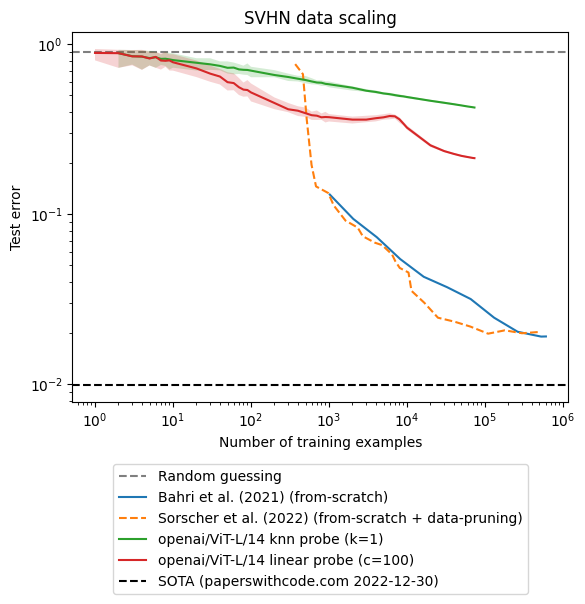

In [22]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)
plt.plot(
    df_prune.n_train,
    df_prune.err,
    label="Sorscher et al. (2022) (from-scratch + data-pruning)",
    linestyle="--",
)
# plt.plot(
#     df_prune_transfer.n_train,
#     df_prune_transfer.err,
#     label="Sorscher et al. (2022) (data pruning + whole-model-finetuning)",
# )
# plt.plot(
#     df_prune_scratch.n_train,
#     df_prune_scratch.err,
#     label="Pruning paper (from scratch)",
# )

for embedder_id in (
    "openai/ViT-L/14",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/microsoft/beit-large-patch16-224",
):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
        label=f"{embedder_id} knn probe (k=1)",
    )
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )
    

# https://paperswithcode.com/sota/image-classification-on-svhn
plt.axhline(
    0.99 / 100,
    color="k",
    linestyle="--",
    label="SOTA (paperswithcode.com 2022-12-30)",
    zorder=-10,
)

plt.title(f"SVHN data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()